In [1]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [27]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

# def dice_loss(inputs, target):
#     num = target.size(0)
#     chans = target.size(1)
#     inputs = inputs.reshape(num*chans, -1)
#     target = target.reshape(num*chans, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / (num*chans)
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
ds_train = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'train'))
ds_test = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'test'))
ds_val = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'val'))

In [6]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [7]:
sample = ds_train.__getitem__(12)

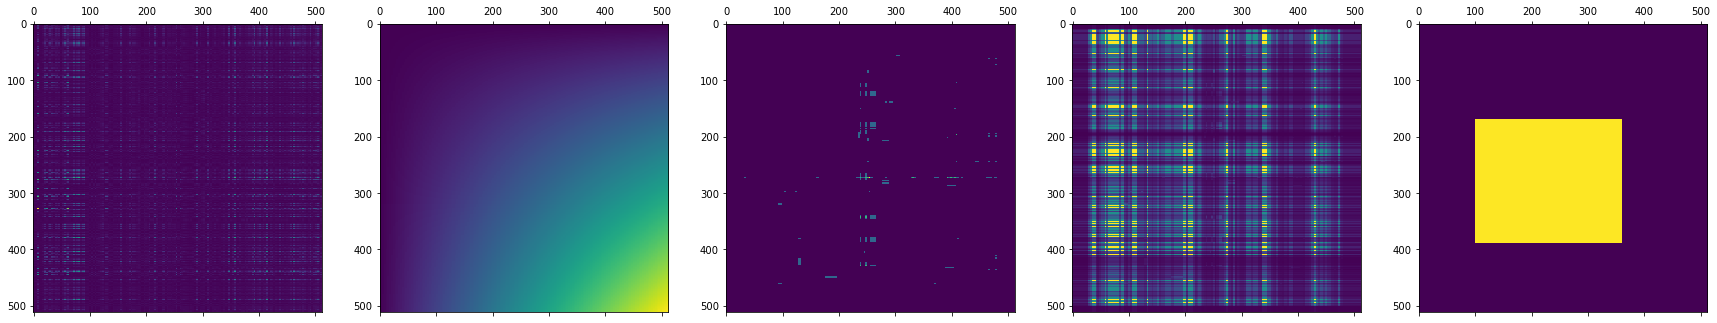

In [8]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [9]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [10]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [11]:
# def dice_metric(inputs, target):
#     intersection = 2.0 * (target * inputs).sum()
#     union = target.sum() + inputs.sum()
#     if target.sum() == 0 and inputs.sum() == 0:
#         return 1.0

#     return intersection / union

# def dice_loss(inputs, target):
#     num = target.size(0)
#     inputs = inputs.reshape(num, -1)
#     target = target.reshape(num, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / num
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

criterion = bce_dice_loss

Setup optimizer

In [12]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [13]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.3115635246973936 val loss 1.2830541559628077
epoch 1 train loss 1.2836891260382306 val loss 1.2875182735068458
epoch 2 train loss 1.2748035034791236 val loss 1.26703280210495
epoch 3 train loss 1.275254570315237 val loss 1.2698127350636892
epoch 4 train loss 1.2763429027501778 val loss 1.2733570039272308
epoch 5 train loss 1.272007190593155 val loss 1.2692048336778368
epoch 6 train loss 1.2717934544845546 val loss 1.2771580197981425
epoch 7 train loss 1.2741770624045299 val loss 1.270016027348382
epoch 8 train loss 1.2740148452899915 val loss 1.27582505771092
epoch 9 train loss 1.271742901727223 val loss 1.2723341477768761
epoch 10 train loss 1.2697210333272482 val loss 1.2635219118424825
epoch 11 train loss 1.2683236890309595 val loss 1.2619033455848694
epoch 12 train loss 1.265396166275435 val loss 1.2551347081150328
epoch 13 train loss 1.2585737937769013 val loss 1.246857383421489
epoch 14 train loss 1.2548413092245436 val loss 1.2366986721754074
epoch 15 train 

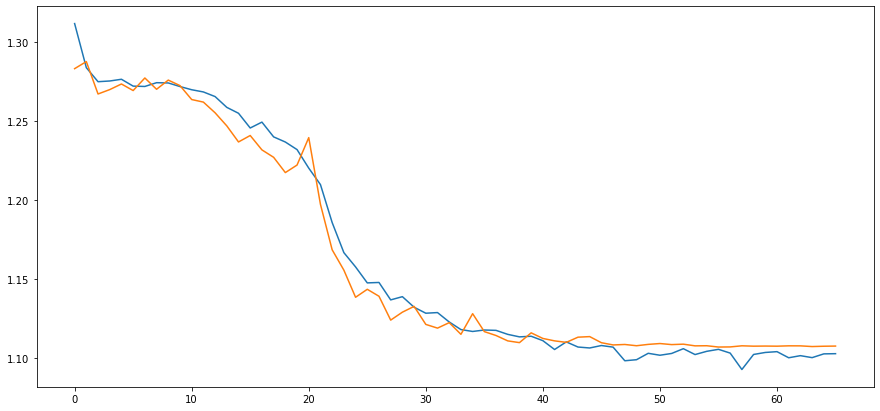

In [15]:
from tqdm.autonotebook import tqdm

epochs = 1000

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= 10:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, './models/unet2D/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= 1-epochs:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [140]:
checkpoint = torch.load('./models/unet2D/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [310]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask.sum(0))
#     cumsum_a = np.cumsum(mask.sum(1))
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1.0-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1.0-tail), side='left'))
#     return range_a, range_b
from scipy import ndimage
def mask_to_box(a):
    objs = ndimage.find_objects(a, max_label=1)

    # Get the height and width
    return objs

In [311]:
# import matplotlib

# cmap = mpl.cm.ScalarMappable
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm)
from matplotlib.patches import Rectangle

def plot_mask(mask_cpu, axx, round=False, title=None, bbs=[]):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    ax = axx.matshow(mask_cpu)
    if title:
        axx.set_title(title)
    axx.set_ylabel('Sequence A')
    axx.set_xlabel('Sequence B')
    ax.set_clim(0, 1)
    axx.set_xticks([])
    axx.set_yticks([])
    
    for bb in bbs:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
    
    plt.colorbar(ax, ax=axx)

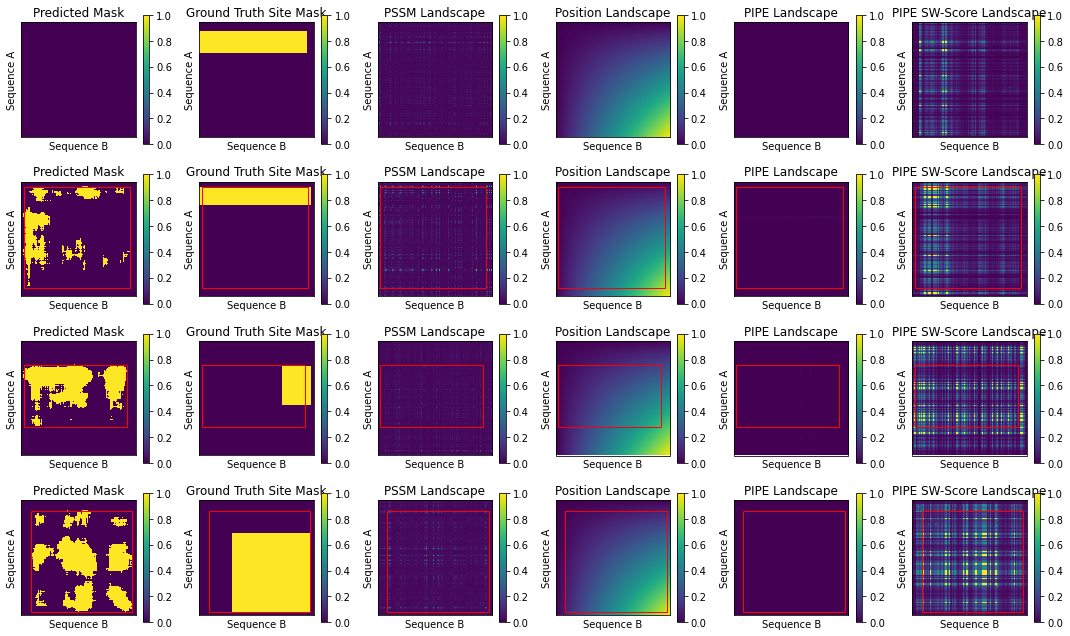

In [312]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(15, 9))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)

        # calculate bounding boxes
        bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(np.int))
#         bb25 = mask_to_box(pred[0,0,:,:], tail=0.25)
#         bb33 = mask_to_box(pred[0,0,:,:], tail=0.4)
        
        plot_mask(pred[0,0,:,:], ax[i][0], round=True, title="Predicted Mask", bbs=bbs)
        plot_mask(y[0,0,:,:], ax[i][1], title='Ground Truth Site Mask', bbs=bbs)
        plot_mask(x[0,0,:,:], ax[i][2], title='PSSM Landscape', bbs=bbs)
        plot_mask(x[0,1,:,:], ax[i][3], title='Position Landscape', bbs=bbs)
        plot_mask(x[0,2,:,:], ax[i][4], title='PIPE Landscape', bbs=bbs)
        plot_mask(x[0,3,:,:], ax[i][5], title='PIPE SW-Score Landscape', bbs=bbs)
        i+=1
        
plt.tight_layout()

# Function to compute the dice accuracy

In [390]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    jacc = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
        jacc.append(jaccard_index(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}, Jaccard Index: {np.mean(jacc)}')

# Compute dice accuracy for train, validation and test data

In [391]:
compute_acc(test_dataloader, model)

Loss: 1.1028552800416946, Accuracy (dice): 0.34308379888534546, Jaccard Index: 0.24601270258426666


In [392]:
compute_acc(train_dataloader, model)

Loss: 1.0996561353783971, Accuracy (dice): 0.34971386194229126, Jaccard Index: 0.24567365646362305


In [393]:
compute_acc(val_dataloader, model)

Loss: 1.1069982882056917, Accuracy (dice): 0.3434436023235321, Jaccard Index: 0.24199436604976654


## Test totally random

In [36]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])
model.cuda()
model.eval()
compute_acc(test_dataloader, model)

Loss: 1.5208478697708674, Accuracy (dice): 0.2256522923707962, Jaccard Index: 0.1351412832736969


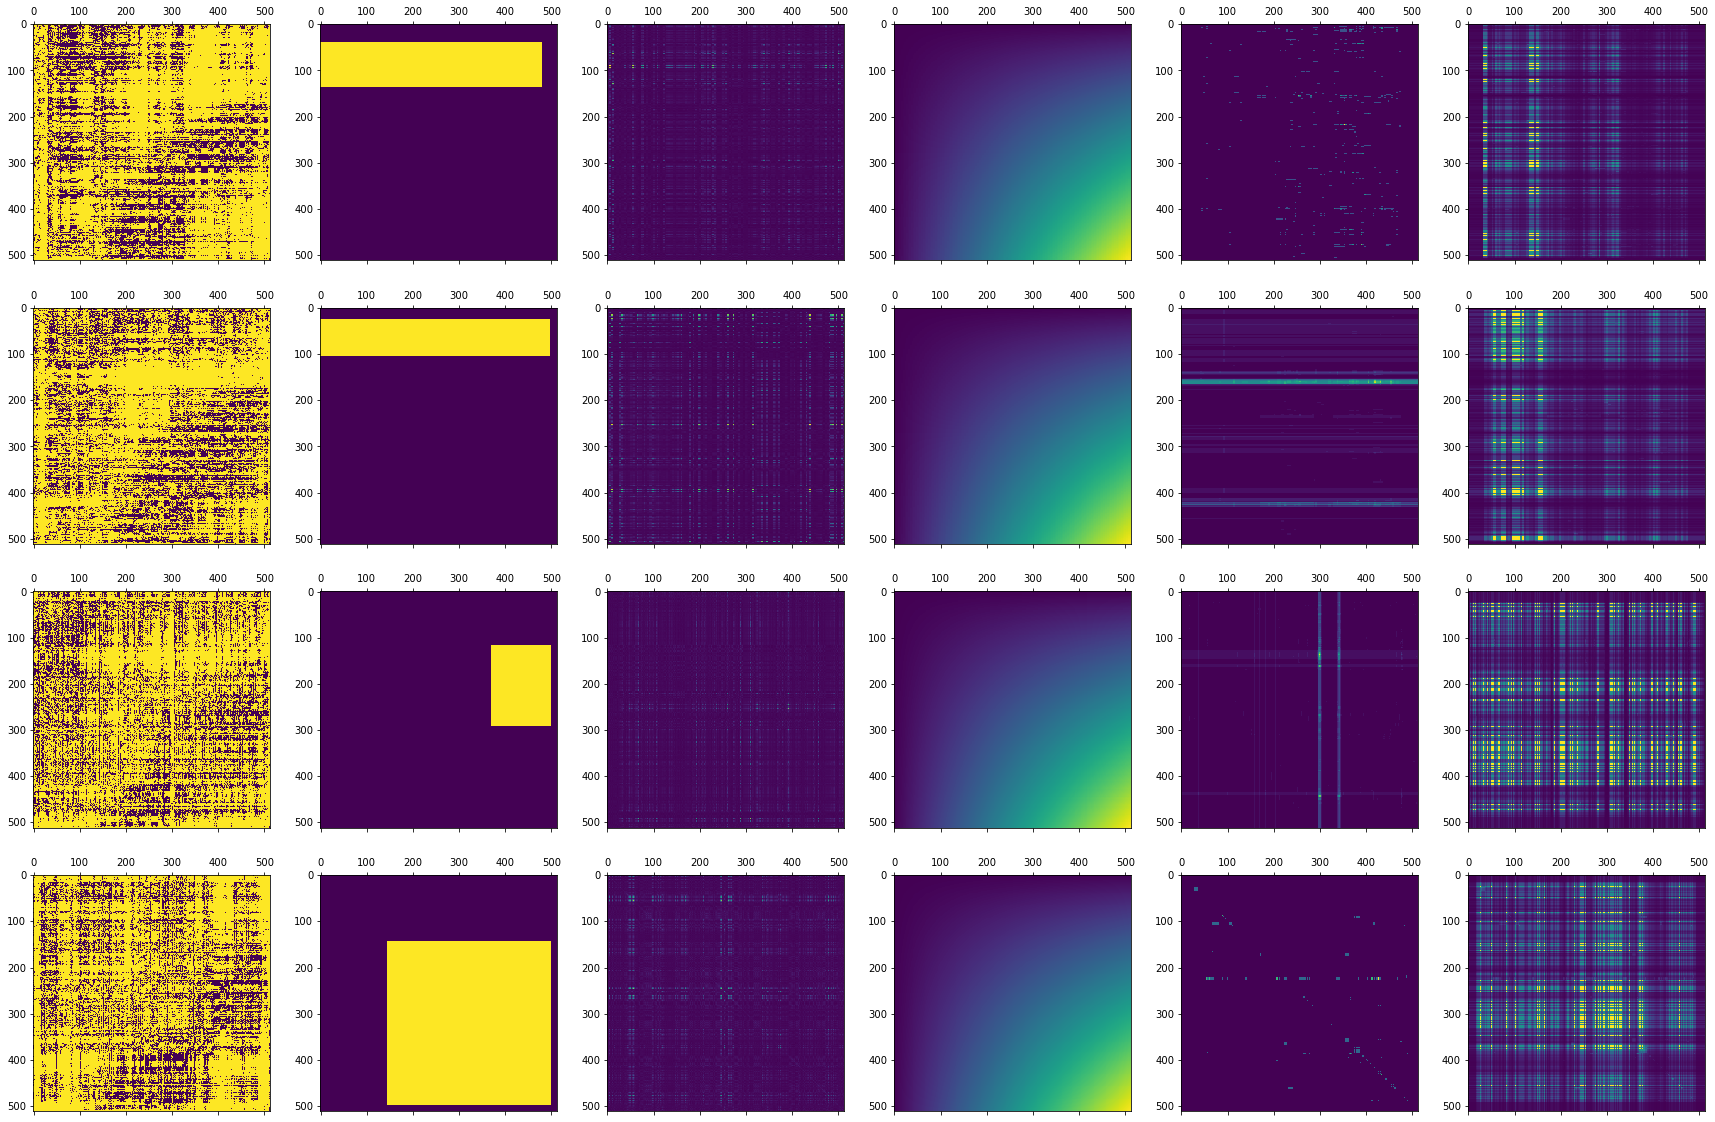

In [37]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Convert to bounding boxes

Create dataset object that can take pair names

In [101]:
class DatasetBB(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 512):
        super(DatasetBB, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        self.pair_names = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )
            self.pair_names.append(os.path.splitext(os.path.basename(img_path))[0])

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label, self.pair_names[index]

    def __len__(self):
        return len(self.img_files)

In [102]:
ds_test = DatasetBB(os.path.join('data', 'yeast_processed_norm_area_50', 'test'))
ds_val = DatasetBB(os.path.join('data', 'yeast_processed_norm_area_50', 'val'))

In [323]:
ds_test.__getitem__(0)

(tensor([[[2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4130e-02, 2.4130e-02, 2.6300e-02,  ..., 3.4546e-02,
           3.4546e-02, 1.7099e-02],
          ...,
          [1.6231e-02, 1.6231e-02, 1.6144e-02,  ..., 1.9096e-02,
           1.9096e-02, 3.3678e-02],
          [1.8054e-02, 1.8054e-02, 1.8835e-02,  ..., 2.8991e-02,
           2.8991e-02, 2.2073e-01],
          [1.5971e-02, 1.5971e-02, 1.5190e-02,  ..., 1.6318e-02,
           1.6318e-02, 2.6126e-02]],
 
         [[6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [1.2585e-05, 1.2585e-05, 2.5170e-05,  ..., 3.9013e-03,
           3.9013e-03, 3.9139e-03],
          ...,
          [3.2028e-03, 3.2028e-03, 6.4057e-03,  ..., 9.928

In [316]:
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

In [315]:
# data, mask, pairname = iter(test_dl).next()

In [105]:
# data.shape, mask.shape

(torch.Size([1, 4, 512, 512]), torch.Size([1, 1, 512, 512]))

In [106]:
# mask.to(device)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [292]:
# pred = model(data.to(device))

In [108]:
# pred.shape

In [116]:
# torch.randn(2, 4).sum(0)

tensor([ 2.1607,  3.9512, -0.8340, -3.1016])

In [121]:
# cumsum_b = np.cumsum(pred.view(512,512).sum(0).cpu().numpy())
# cumsum_a = np.cumsum(pred.view(512,512).sum(1).cpu().numpy())

In [132]:
# tail=0.25
# np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail)), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail))

(128, 384)

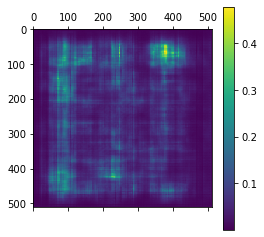

In [291]:
# plt.matshow(pred[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

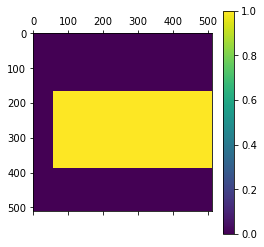

In [239]:
# plt.matshow(mask[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [198]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask[0,0,:,:].max(0).cpu().numpy())
#     cumsum_a = np.cumsum(mask[0,0,:,:].max(1).cpu().numpy())
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))
#     return range_a, range_b

In [269]:
# cumsum_b = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=0)))
# cumsum_a = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=1)))

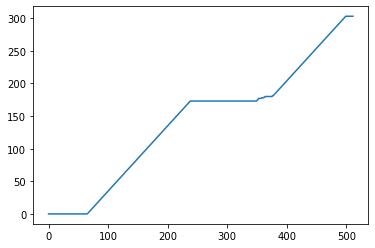

In [270]:
# plt.plot(cumsum_b)

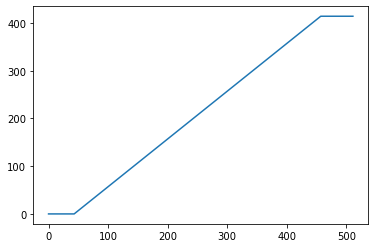

In [271]:
# plt.plot(cumsum_a)

In [261]:
# tail=0.20
# (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))

(256, 409)

In [262]:
# (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))

(103, 409)

In [222]:
# np.quantile(cumsum_a, tail)

1752.8921630859377

In [223]:
# np.quantile(cumsum_b, tail)

1828.6241333007813

In [309]:
# ndimage.find_objects(np.zeros((50,50), dtype=np.int), max_label=1)

[None]

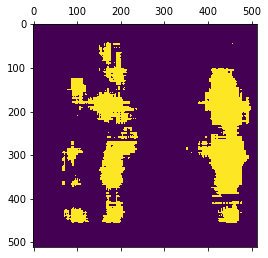

In [293]:
# plt.matshow(pred[0,0,:,:].cpu().numpy().round().astype(int))

In [314]:
# mask_to_box(mask[0,0,:,:].cpu().numpy().round().astype(int))

[(slice(170, 389, None), slice(56, 511, None))]

## Get predictions and turn them into bounding boxes

In [372]:
bb_preds_test = []
bb_trues_test = []
pairnames_test = []
for _, (data, mask, pairname) in enumerate(test_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int)
    
    bb_preds_test.append(mask_to_box(pred))
    bb_trues_test.append(mask_to_box(mask))
    pairnames_test.append(pairname)
    
bb_preds_val = []
bb_trues_val = []
pairnames_val = []
for _, (data, mask, pairname) in enumerate(val_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int)
    
    bb_preds_val.append(mask_to_box(pred))
    bb_trues_val.append(mask_to_box(mask))
    pairnames_val.append(pairname)
    
import pandas as pd
test_df = pd.DataFrame(list(zip(pairnames_test, bb_preds_test, bb_trues_test)), columns=['pair', 'pred', 'true'])
val_df = pd.DataFrame(list(zip(pairnames_val, bb_preds_val, bb_trues_val)), columns=['pair', 'pred', 'true'])

In [373]:
test_df

,pair,pred,true
0,"(P00830_P38077,)","[(slice(44, 458, None), slice(66, 500, None))]","[(slice(170, 389, None), slice(56, 511, None))]"
1,"(P06245_P05986,)","[(slice(90, 466, None), slice(84, 458, None))]","[(slice(93, 437, None), slice(112, 440, None))]"
2,"(P06780_P51862,)","[(slice(14, 454, None), slice(152, 498, None))]","[(slice(27, 454, None), slice(250, 319, None))]"
3,"(P06782_P38717,)","[(slice(42, 246, None), slice(10, 494, None))]","[(slice(44, 248, None), slice(129, 177, None))]"
4,"(P08018_P53599,)","[(slice(270, 474, None), slice(94, 502, None))]","[(slice(276, 478, None), slice(411, 506, None))]"
...,...,...,...
106,"(Q12189_Q12189,)","[(slice(46, 494, None), slice(46, 499, None))]","[(slice(145, 499, None), slice(145, 499, None))]"
107,"(Q12223_Q12223,)","[(slice(50, 453, None), slice(54, 450, None))]","[(slice(99, 433, None), slice(99, 433, None))]"
108,"(Q12329_Q12329,)","[(slice(27, 474, None), slice(22, 474, None))]","[(slice(336, 487, None), slice(336, 487, None))]"
109,"(Q12438_Q12438,)","[(slice(38, 486, None), slice(38, 477, None))]","[(slice(282, 428, None), slice(282, 428, None))]"


In [376]:
# -1 to make inclusive
deslice = lambda x: np.asarray([[x[0][0].start, x[0][0].stop-1], [x[0][1].start, x[0][1].stop-1]])

In [377]:
test_df[['pred', 'true']] = test_df[['pred', 'true']].applymap(deslice)
val_df[['pred', 'true']] = val_df[['pred', 'true']].applymap(deslice)

In [378]:
test_df

,pair,pred,true
0,"(P00830_P38077,)","[[44, 457], [66, 499]]","[[170, 388], [56, 510]]"
1,"(P06245_P05986,)","[[90, 465], [84, 457]]","[[93, 436], [112, 439]]"
2,"(P06780_P51862,)","[[14, 453], [152, 497]]","[[27, 453], [250, 318]]"
3,"(P06782_P38717,)","[[42, 245], [10, 493]]","[[44, 247], [129, 176]]"
4,"(P08018_P53599,)","[[270, 473], [94, 501]]","[[276, 477], [411, 505]]"
...,...,...,...
106,"(Q12189_Q12189,)","[[46, 493], [46, 498]]","[[145, 498], [145, 498]]"
107,"(Q12223_Q12223,)","[[50, 452], [54, 449]]","[[99, 432], [99, 432]]"
108,"(Q12329_Q12329,)","[[27, 473], [22, 473]]","[[336, 486], [336, 486]]"
109,"(Q12438_Q12438,)","[[38, 485], [38, 476]]","[[282, 427], [282, 427]]"


Get lengths of proteins

In [379]:
protein_sequence = "data/uniprot-proteome_UP000002311_stripped.fasta"
protein_sequence_CD = pd.read_csv(protein_sequence, header = None, sep = "\t")
print("Loaded UniProt proteome")
new_df_ps = pd.DataFrame(index = protein_sequence_CD[0].iloc[::2].map(lambda x: str(x)[1:].strip()))
new_df_ps['Sequence'] = protein_sequence_CD[0].iloc[1::2].to_numpy()
new_df_ps['Length'] = new_df_ps['Sequence'].map(lambda x: len(x))
new_df_ps

Loaded UniProt proteome


,Sequence,Length
0,,
P21192,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...,770
P46993,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...,209
P47117,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...,449
P22768,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...,420
P29311,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...,267
...,...,...
P47049,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...,396
P53142,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...,486
Q05919,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...,439


In [380]:
test_df['pair'] = test_df['pair'].apply(lambda x: x[0]).str.split(pat='_')
test_df

,pair,pred,true
0,"[P00830, P38077]","[[44, 457], [66, 499]]","[[170, 388], [56, 510]]"
1,"[P06245, P05986]","[[90, 465], [84, 457]]","[[93, 436], [112, 439]]"
2,"[P06780, P51862]","[[14, 453], [152, 497]]","[[27, 453], [250, 318]]"
3,"[P06782, P38717]","[[42, 245], [10, 493]]","[[44, 247], [129, 176]]"
4,"[P08018, P53599]","[[270, 473], [94, 501]]","[[276, 477], [411, 505]]"
...,...,...,...
106,"[Q12189, Q12189]","[[46, 493], [46, 498]]","[[145, 498], [145, 498]]"
107,"[Q12223, Q12223]","[[50, 452], [54, 449]]","[[99, 432], [99, 432]]"
108,"[Q12329, Q12329]","[[27, 473], [22, 473]]","[[336, 486], [336, 486]]"
109,"[Q12438, Q12438]","[[38, 485], [38, 476]]","[[282, 427], [282, 427]]"


In [381]:
test_df[['protein_a', 'protein_b']] = pd.DataFrame(test_df['pair'].tolist(), index=test_df.index)
test_df.drop(['pair'], inplace=True, axis=1)
test_df

,pred,true,protein_a,protein_b
0,"[[44, 457], [66, 499]]","[[170, 388], [56, 510]]",P00830,P38077
1,"[[90, 465], [84, 457]]","[[93, 436], [112, 439]]",P06245,P05986
2,"[[14, 453], [152, 497]]","[[27, 453], [250, 318]]",P06780,P51862
3,"[[42, 245], [10, 493]]","[[44, 247], [129, 176]]",P06782,P38717
4,"[[270, 473], [94, 501]]","[[276, 477], [411, 505]]",P08018,P53599
...,...,...,...,...
106,"[[46, 493], [46, 498]]","[[145, 498], [145, 498]]",Q12189,Q12189
107,"[[50, 452], [54, 449]]","[[99, 432], [99, 432]]",Q12223,Q12223
108,"[[27, 473], [22, 473]]","[[336, 486], [336, 486]]",Q12329,Q12329
109,"[[38, 485], [38, 476]]","[[282, 427], [282, 427]]",Q12438,Q12438


In [382]:
test_df['len_a'] = test_df['protein_a'].apply(lambda x: new_df_ps.Length.loc[x])
test_df['len_b'] = test_df['protein_b'].apply(lambda x: new_df_ps.Length.loc[x])
test_df

,pred,true,protein_a,protein_b,len_a,len_b
0,"[[44, 457], [66, 499]]","[[170, 388], [56, 510]]",P00830,P38077,511,311
1,"[[90, 465], [84, 457]]","[[93, 436], [112, 439]]",P06245,P05986,380,398
2,"[[14, 453], [152, 497]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356
3,"[[42, 245], [10, 493]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229
4,"[[270, 473], [94, 501]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579
...,...,...,...,...,...,...
106,"[[46, 493], [46, 498]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258
107,"[[50, 452], [54, 449]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238
108,"[[27, 473], [22, 473]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375
109,"[[38, 485], [38, 476]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231


In [383]:
# Formula adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_dice_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0][0] < bb1[0][1]
    assert bb1[1][0] < bb1[1][1]
    assert bb2[0][0] < bb2[0][1]
    assert bb2[1][0] < bb2[1][1]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[1][0], bb2[1][0])
    y_top = max(bb1[0][0], bb2[0][0])
    x_right = min(bb1[1][1], bb2[1][1])
    y_bottom = min(bb1[0][1], bb2[0][1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[1][1] - bb1[1][0] + 1) * (bb1[0][1] - bb1[0][0] + 1)
    bb2_area = (bb2[1][1] - bb2[1][0] + 1) * (bb2[0][1] - bb2[0][0] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # dice
    dice =  2 * intersection_area / float(bb1_area + bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou, dice

In [384]:
test_df['iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
test_df[['iou', 'dice']] = pd.DataFrame(test_df['iou_dice'].tolist(), index=test_df.index)
test_df.drop(['iou_dice'], inplace=True, axis=1)

val_df['iou_dice'] = val_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
val_df[['iou', 'dice']] = pd.DataFrame(val_df['iou_dice'].tolist(), index=val_df.index)
val_df.drop(['iou_dice'], inplace=True, axis=1)

In [385]:
test_df

,pred,true,protein_a,protein_b,len_a,len_b,iou,dice
0,"[[44, 457], [66, 499]]","[[170, 388], [56, 510]]",P00830,P38077,511,311,0.515783,0.680550
1,"[[90, 465], [84, 457]]","[[93, 436], [112, 439]]",P06245,P05986,380,398,0.802367,0.890348
2,"[[14, 453], [152, 497]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356,0.193530,0.324298
3,"[[42, 245], [10, 493]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229,0.098106,0.178682
4,"[[270, 473], [94, 501]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579,0.213473,0.351838
...,...,...,...,...,...,...,...,...
106,"[[46, 493], [46, 498]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258,0.603505,0.752733
107,"[[50, 452], [54, 449]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238,0.699025,0.822854
108,"[[27, 473], [22, 473]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375,0.092536,0.169397
109,"[[38, 485], [38, 476]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231,0.108384,0.195570


In [386]:
val_df

,pair,pred,true,iou,dice
0,"(O94742_P46674,)","[[54, 475], [68, 491]]","[[116, 477], [78, 197]]",0.241114,0.388545
1,"(P00546_P20486,)","[[35, 473], [29, 361]]","[[13, 506], [93, 354]]",0.716190,0.834628
2,"(P00830_P30902,)","[[46, 465], [19, 449]]","[[170, 388], [9, 464]]",0.506121,0.672085
3,"(P02829_P38080,)","[[22, 485], [10, 167]]","[[132, 509], [31, 146]]",0.539634,0.700990
4,"(P03069_P03069,)","[[94, 485], [90, 493]]","[[407, 502], [407, 502]]",0.042766,0.082025
...,...,...,...,...,...
107,"(Q12241_P36015,)","[[50, 453], [45, 478]]","[[408, 502], [349, 504]]",0.032469,0.062896
108,"(Q12330_Q08963,)","[[42, 493], [50, 380]]","[[99, 501], [99, 389]]",0.716357,0.834742
109,"(Q12449_P53834,)","[[10, 473], [34, 449]]","[[18, 219], [41, 491]]",0.409999,0.581559
110,"(Q12460_P39990,)","[[59, 465], [34, 433]]","[[182, 420], [70, 455]]",0.517655,0.682177


## Distance Measure

The distance measure is as described in PIPE-Sites: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-225

In [387]:
def dm(pred, true, len_a, len_b):
    
    assert pred[0][0] < pred[0][1]
    assert pred[1][0] < pred[1][1]
    assert true[0][0] < true[0][1]
    assert true[1][0] < true[1][1]
    
    delta_a = max(true[0][0]-pred[0][0], pred[0][1]-true[0][1], 0)/len_a
    delta_b = max(true[1][0]-pred[1][0], pred[1][1]-true[1][1], 0)/len_b
    
    result = ((delta_a**2 + delta_b**2)**0.5)/(2**0.5)
    
    return result

In [388]:
test_df['dm'] = test_df.apply(lambda x: dm(x.pred, x.true, 512, 512), axis=1)
test_df

,pred,true,protein_a,protein_b,len_a,len_b,iou,dice,dm
0,"[[44, 457], [66, 499]]","[[170, 388], [56, 510]]",P00830,P38077,511,311,0.515783,0.680550,0.174015
1,"[[90, 465], [84, 457]]","[[93, 436], [112, 439]]",P06245,P05986,380,398,0.802367,0.890348,0.055673
2,"[[14, 453], [152, 497]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356,0.193530,0.324298,0.247862
3,"[[42, 245], [10, 493]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229,0.098106,0.178682,0.437807
4,"[[270, 473], [94, 501]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579,0.213473,0.351838,0.437877
...,...,...,...,...,...,...,...,...,...
106,"[[46, 493], [46, 498]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258,0.603505,0.752733,0.193359
107,"[[50, 452], [54, 449]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238,0.699025,0.822854,0.091880
108,"[[27, 473], [22, 473]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375,0.092536,0.169397,0.608418
109,"[[38, 485], [38, 476]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231,0.108384,0.195570,0.476562


In [389]:
test_df[['iou', 'dice', 'dm']].describe()

,iou,dice,dm
count,111.000000,111.000000,111.000000
mean,0.244119,0.348910,0.394143
std,0.218831,0.253292,0.191760
min,0.000000,0.000000,0.028738
25%,0.086190,0.158638,0.256285
50%,0.181032,0.306566,0.408805
75%,0.346241,0.514341,0.510769
max,0.861363,0.925518,0.862711
